In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

/home/ubuntu/anaconda3/envs/bnntest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda")

In [ ]:
#from utils.model import LaplaceBayesianCNNSingleFCCustom

In [ ]:
class LaplaceBayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes, device):
        super().__init__()

        prior_mu = 0.
        prior_b = torch.tensor(1., device=device)

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Laplace(prior_mu, prior_b).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Laplace(prior_mu, prior_b).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Laplace(prior_mu, prior_b).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Laplace(prior_mu, prior_b).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling to reduce [B, 64, 16, 16] → [B, 64]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer: 64 → num_classes
        self.fc1 = PyroModule[nn.Linear](64, num_classes)
        self.fc1.weight = PyroSample(dist.Laplace(prior_mu, prior_b).expand([num_classes, 64]).to_event(2))
        self.fc1.bias = PyroSample(dist.Laplace(prior_mu, prior_b).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        # x: [B, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits

In [4]:
class BayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes, device):
        super().__init__()

        prior_mu = 0
        prior_b = torch.tensor(10., device=device)

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling to reduce [B, 64, 16, 16] → [B, 64]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer: 64 → num_classes
        self.fc1 = PyroModule[nn.Linear](64, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes, 64]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        # x: [B, 3, 64, 64]
        x = self.pool(F.tanh(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.tanh(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits

In [ ]:
"""
class BayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes, device):
        super().__init__()

        prior_mu = 0.
        prior_b = torch.tensor(10., device=device)

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Change: Output shape will be [B, 64, 2, 2] after GAP
        self.gap = nn.AdaptiveAvgPool2d((2, 2))

        # Flattened output size: 64 channels × 2 × 2 = 256
        self.fc1 = PyroModule[nn.Linear](256, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes, 256]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        # Input: [B, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 2, 2]
        x = x.view(x.size(0), -1)             # → [B, 256]
        logits = self.fc1(x)                  # → [B, num_classes]

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits
"""

In [5]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3803, 0.4078], 
                             std=[0.0914, 0.0651, 0.0552])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=True)

    torch.manual_seed(42)

    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [6]:
num_classes = 10
#bayesian_model = LaplaceBayesianCNNSingleFCCustom(num_classes=num_classes, 
#                                                  device=device,
#                                                  mu=0., b=10.)
bayesian_model = BayesianCNNSingleFC(num_classes=num_classes, device=device)

In [7]:
from pyro.infer.autoguide import AutoDiagonalNormal
#from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import Adam

In [8]:
guide = AutoDiagonalNormal(bayesian_model)
#guide = AutoLowRankMultivariateNormal(bayesian_model, rank=20)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO(num_particles=1,
                                                )) #TODO

In [9]:
from tqdm import tqdm

In [10]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")

In [11]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [12]:
def train_svi_with_annealing(model, guide, svi, train_loader, num_epochs=10):
    pyro.clear_param_store()
    model.train()
    model.to(device)
    
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        # KL annealing - gradually increase KL weight
        kl_weight = min(1.0, (epoch + 1) / (num_epochs * 0.5))  # Reach full weight at 50% of training
        
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Use weighted ELBO
            def weighted_model(images, labels):
                with pyro.poutine.scale(scale=kl_weight):
                    return model(images, labels)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)

        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [13]:
def train_svi_with_stats(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Lists to store weight and bias statistics
    weight_stats = {'epochs': [], 'means': [], 'stds': []}
    bias_stats = {'epochs': [], 'means': [], 'stds': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Record weight and bias statistics
            weight_means = []
            weight_stds = []
            bias_means = []
            bias_stds = []
            
            for name, param in pyro.get_param_store().items():
                if 'AutoDiagonalNormal.loc' in name:
                    weight_means.append(param.mean().item())
                    weight_stds.append(param.std().item())
                elif 'AutoDiagonalNormal.scale' in name:
                    bias_means.append(param.mean().item())
                    bias_stds.append(param.std().item())
            
            # Store statistics for this epoch
            weight_stats['epochs'].append(epoch + 1)
            weight_stats['means'].append(weight_means)
            weight_stats['stds'].append(weight_stds)
            
            bias_stats['epochs'].append(epoch + 1)
            bias_stats['means'].append(bias_means)
            bias_stats['stds'].append(bias_stds)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, weight_stats, bias_stats

def plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats):
    """Plot training results with weight and bias statistics"""
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid(True)
    
    # Plot 2: Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_epochs, accuracies, 'o-')
    plt.title('Training Accuracy (Every 10 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Plot 3: Weight Statistics Boxplot
    plt.subplot(2, 2, 3)
    weight_data = []
    weight_labels = []
    
    for i, epoch in enumerate(weight_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = weight_stats['means'][i] + weight_stats['stds'][i]
        weight_data.append(epoch_data)
        weight_labels.append(f'Epoch {epoch}')
    
    if weight_data:
        bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.title('LOC Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('LOC Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Bias Statistics Boxplot
    plt.subplot(2, 2, 4)
    bias_data = []
    bias_labels = []
    
    for i, epoch in enumerate(bias_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = bias_stats['means'][i] + bias_stats['stds'][i]
        bias_data.append(epoch_data)
        bias_labels.append(f'Epoch {epoch}')
    
    if bias_data:
        bp2 = plt.boxplot(bias_data, tick_labels=bias_labels, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('lightcoral')
    
    plt.title('SCALE Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('SCALE Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [14]:
from tqdm import tqdm

In [15]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with statistics recording
losses, accuracies, accuracy_epochs, weight_stats, bias_stats = train_svi_with_stats(
    bayesian_model, guide, svi, train_loader, num_epochs=100 #TODO
)

Calculating accuracy for epoch 1: 100%|██████████| 400/400 [00:06<00:00, 60.83it/s]


Epoch 1 - ELBO Loss: 216144.0952, Train Accuracy: 42.67%


Epoch 2/100: 100%|██████████| 400/400 [00:08<00:00, 45.02it/s]


Epoch 2 - ELBO Loss: 195859.8960


Epoch 3/100: 100%|██████████| 400/400 [00:08<00:00, 46.78it/s]


Epoch 3 - ELBO Loss: 176735.0760


Epoch 4/100: 100%|██████████| 400/400 [00:08<00:00, 47.24it/s]


Epoch 4 - ELBO Loss: 158756.6430


Epoch 5/100: 100%|██████████| 400/400 [00:08<00:00, 46.67it/s]


Epoch 5 - ELBO Loss: 142175.2957


Epoch 6/100: 100%|██████████| 400/400 [00:08<00:00, 45.04it/s]


Epoch 6 - ELBO Loss: 127103.7229


Epoch 7/100: 100%|██████████| 400/400 [00:08<00:00, 44.83it/s]


Epoch 7 - ELBO Loss: 113631.9882


Epoch 8/100: 100%|██████████| 400/400 [00:08<00:00, 47.03it/s]


Epoch 8 - ELBO Loss: 101695.5384


Epoch 9/100: 100%|██████████| 400/400 [00:08<00:00, 47.64it/s]


Epoch 9 - ELBO Loss: 91259.2221


Calculating accuracy for epoch 10: 100%|██████████| 400/400 [00:05<00:00, 79.94it/s]


Epoch 10 - ELBO Loss: 82148.5372, Train Accuracy: 33.62%


Epoch 11/100: 100%|██████████| 400/400 [00:08<00:00, 46.98it/s]


Epoch 11 - ELBO Loss: 74205.1086


Epoch 12/100: 100%|██████████| 400/400 [00:08<00:00, 47.39it/s]


Epoch 12 - ELBO Loss: 67227.8163


Epoch 13/100: 100%|██████████| 400/400 [00:08<00:00, 47.10it/s]


Epoch 13 - ELBO Loss: 61051.7257


Epoch 14/100: 100%|██████████| 400/400 [00:08<00:00, 46.89it/s]


Epoch 14 - ELBO Loss: 55620.4112


Epoch 15/100: 100%|██████████| 400/400 [00:08<00:00, 47.67it/s]


Epoch 15 - ELBO Loss: 50793.1793


Epoch 16/100: 100%|██████████| 400/400 [00:08<00:00, 47.49it/s]


Epoch 16 - ELBO Loss: 46530.1090


Epoch 17/100: 100%|██████████| 400/400 [00:08<00:00, 47.19it/s]


Epoch 17 - ELBO Loss: 42684.1528


Epoch 18/100: 100%|██████████| 400/400 [00:08<00:00, 47.97it/s]


Epoch 18 - ELBO Loss: 39198.6071


Epoch 19/100: 100%|██████████| 400/400 [00:08<00:00, 47.17it/s]


Epoch 19 - ELBO Loss: 36080.6190


Calculating accuracy for epoch 20: 100%|██████████| 400/400 [00:04<00:00, 80.99it/s]


Epoch 20 - ELBO Loss: 33270.9899, Train Accuracy: 26.47%


Epoch 21/100: 100%|██████████| 400/400 [00:08<00:00, 47.33it/s]


Epoch 21 - ELBO Loss: 30757.6460


Epoch 22/100: 100%|██████████| 400/400 [00:08<00:00, 46.67it/s]


Epoch 22 - ELBO Loss: 28480.8962


Epoch 23/100: 100%|██████████| 400/400 [00:08<00:00, 46.64it/s]


Epoch 23 - ELBO Loss: 26429.2966


Epoch 24/100: 100%|██████████| 400/400 [00:08<00:00, 47.76it/s]


Epoch 24 - ELBO Loss: 24590.9554


Epoch 25/100: 100%|██████████| 400/400 [00:08<00:00, 47.31it/s]


Epoch 25 - ELBO Loss: 22916.6989


Epoch 26/100: 100%|██████████| 400/400 [00:08<00:00, 47.12it/s]


Epoch 26 - ELBO Loss: 21370.9354


Epoch 27/100: 100%|██████████| 400/400 [00:08<00:00, 46.75it/s]


Epoch 27 - ELBO Loss: 19951.6599


Epoch 28/100: 100%|██████████| 400/400 [00:08<00:00, 47.25it/s]


Epoch 28 - ELBO Loss: 18686.0937


Epoch 29/100: 100%|██████████| 400/400 [00:08<00:00, 47.18it/s]


Epoch 29 - ELBO Loss: 17525.0150


Calculating accuracy for epoch 30: 100%|██████████| 400/400 [00:04<00:00, 80.69it/s]


Epoch 30 - ELBO Loss: 16467.9365, Train Accuracy: 23.94%


Epoch 31/100: 100%|██████████| 400/400 [00:08<00:00, 46.73it/s]


Epoch 31 - ELBO Loss: 15449.1476


Epoch 32/100: 100%|██████████| 400/400 [00:08<00:00, 46.31it/s]


Epoch 32 - ELBO Loss: 14523.7145


Epoch 33/100: 100%|██████████| 400/400 [00:08<00:00, 47.33it/s]


Epoch 33 - ELBO Loss: 13688.1373


Epoch 34/100: 100%|██████████| 400/400 [00:08<00:00, 47.20it/s]


Epoch 34 - ELBO Loss: 12896.0065


Epoch 35/100: 100%|██████████| 400/400 [00:08<00:00, 46.48it/s]


Epoch 35 - ELBO Loss: 12188.4918


Epoch 36/100: 100%|██████████| 400/400 [00:08<00:00, 46.43it/s]


Epoch 36 - ELBO Loss: 11534.3495


Epoch 37/100: 100%|██████████| 400/400 [00:08<00:00, 47.29it/s]


Epoch 37 - ELBO Loss: 10908.2922


Epoch 38/100: 100%|██████████| 400/400 [00:08<00:00, 47.04it/s]


Epoch 38 - ELBO Loss: 10342.1337


Epoch 39/100: 100%|██████████| 400/400 [00:08<00:00, 46.03it/s]


Epoch 39 - ELBO Loss: 9870.3380


Calculating accuracy for epoch 40: 100%|██████████| 400/400 [00:04<00:00, 80.38it/s]


Epoch 40 - ELBO Loss: 9401.7531, Train Accuracy: 22.91%


Epoch 41/100: 100%|██████████| 400/400 [00:08<00:00, 46.89it/s]


Epoch 41 - ELBO Loss: 8958.6849


Epoch 42/100: 100%|██████████| 400/400 [00:08<00:00, 47.32it/s]


Epoch 42 - ELBO Loss: 8567.2496


Epoch 43/100: 100%|██████████| 400/400 [00:08<00:00, 47.09it/s]


Epoch 43 - ELBO Loss: 8191.6185


Epoch 44/100: 100%|██████████| 400/400 [00:08<00:00, 46.54it/s]


Epoch 44 - ELBO Loss: 7864.3796


Epoch 45/100: 100%|██████████| 400/400 [00:08<00:00, 47.01it/s]


Epoch 45 - ELBO Loss: 7548.3870


Epoch 46/100: 100%|██████████| 400/400 [00:08<00:00, 47.12it/s]


Epoch 46 - ELBO Loss: 7268.6207


Epoch 47/100: 100%|██████████| 400/400 [00:08<00:00, 46.95it/s]


Epoch 47 - ELBO Loss: 6963.0636


Epoch 48/100: 100%|██████████| 400/400 [00:08<00:00, 46.93it/s]


Epoch 48 - ELBO Loss: 6721.6254


Epoch 49/100: 100%|██████████| 400/400 [00:08<00:00, 47.08it/s]


Epoch 49 - ELBO Loss: 6484.6265


Calculating accuracy for epoch 50: 100%|██████████| 400/400 [00:04<00:00, 80.26it/s]


Epoch 50 - ELBO Loss: 6259.1295, Train Accuracy: 23.55%


Epoch 51/100: 100%|██████████| 400/400 [00:08<00:00, 46.42it/s]


Epoch 51 - ELBO Loss: 6064.5037


Epoch 52/100: 100%|██████████| 400/400 [00:08<00:00, 46.56it/s]


Epoch 52 - ELBO Loss: 5866.2612


Epoch 53/100: 100%|██████████| 400/400 [00:08<00:00, 46.43it/s]


Epoch 53 - ELBO Loss: 5704.1431


Epoch 54/100: 100%|██████████| 400/400 [00:08<00:00, 47.48it/s]


Epoch 54 - ELBO Loss: 5543.3311


Epoch 55/100: 100%|██████████| 400/400 [00:08<00:00, 46.38it/s]


Epoch 55 - ELBO Loss: 5385.3088


Epoch 56/100: 100%|██████████| 400/400 [00:08<00:00, 46.56it/s]


Epoch 56 - ELBO Loss: 5223.7556


Epoch 57/100: 100%|██████████| 400/400 [00:08<00:00, 47.35it/s]


Epoch 57 - ELBO Loss: 5093.7953


Epoch 58/100: 100%|██████████| 400/400 [00:08<00:00, 47.47it/s]


Epoch 58 - ELBO Loss: 4961.9425


Epoch 59/100: 100%|██████████| 400/400 [00:08<00:00, 47.55it/s]


Epoch 59 - ELBO Loss: 4833.0027


Calculating accuracy for epoch 60: 100%|██████████| 400/400 [00:04<00:00, 81.43it/s]


Epoch 60 - ELBO Loss: 4730.1106, Train Accuracy: 22.65%


Epoch 61/100: 100%|██████████| 400/400 [00:08<00:00, 47.23it/s]


Epoch 61 - ELBO Loss: 4594.2000


Epoch 62/100: 100%|██████████| 400/400 [00:08<00:00, 47.62it/s]


Epoch 62 - ELBO Loss: 4501.9379


Epoch 63/100: 100%|██████████| 400/400 [00:08<00:00, 47.12it/s]


Epoch 63 - ELBO Loss: 4405.8819


Epoch 64/100: 100%|██████████| 400/400 [00:08<00:00, 47.18it/s]


Epoch 64 - ELBO Loss: 4321.7406


Epoch 65/100: 100%|██████████| 400/400 [00:08<00:00, 47.47it/s]


Epoch 65 - ELBO Loss: 4247.8294


Epoch 66/100: 100%|██████████| 400/400 [00:08<00:00, 47.05it/s]


Epoch 66 - ELBO Loss: 4159.1729


Epoch 67/100: 100%|██████████| 400/400 [00:08<00:00, 47.10it/s]


Epoch 67 - ELBO Loss: 4073.3821


Epoch 68/100: 100%|██████████| 400/400 [00:08<00:00, 46.57it/s]


Epoch 68 - ELBO Loss: 4011.5083


Epoch 69/100: 100%|██████████| 400/400 [00:08<00:00, 46.32it/s]


Epoch 69 - ELBO Loss: 3940.3489


Calculating accuracy for epoch 70: 100%|██████████| 400/400 [00:04<00:00, 80.95it/s]


Epoch 70 - ELBO Loss: 3874.8940, Train Accuracy: 23.27%


Epoch 71/100: 100%|██████████| 400/400 [00:08<00:00, 47.15it/s]


Epoch 71 - ELBO Loss: 3828.9611


Epoch 72/100: 100%|██████████| 400/400 [00:08<00:00, 46.42it/s]


Epoch 72 - ELBO Loss: 3774.1495


Epoch 73/100: 100%|██████████| 400/400 [00:08<00:00, 47.52it/s]


Epoch 73 - ELBO Loss: 3697.3790


Epoch 74/100: 100%|██████████| 400/400 [00:08<00:00, 47.12it/s]


Epoch 74 - ELBO Loss: 3666.6434


Epoch 75/100: 100%|██████████| 400/400 [00:08<00:00, 47.18it/s]


Epoch 75 - ELBO Loss: 3610.4744


Epoch 76/100: 100%|██████████| 400/400 [00:08<00:00, 47.00it/s]


Epoch 76 - ELBO Loss: 3553.7080


Epoch 77/100: 100%|██████████| 400/400 [00:08<00:00, 47.56it/s]


Epoch 77 - ELBO Loss: 3493.1169


Epoch 78/100: 100%|██████████| 400/400 [00:08<00:00, 47.30it/s]


Epoch 78 - ELBO Loss: 3433.5106


Epoch 79/100: 100%|██████████| 400/400 [00:08<00:00, 47.43it/s]


Epoch 79 - ELBO Loss: 3407.5999


Calculating accuracy for epoch 80: 100%|██████████| 400/400 [00:04<00:00, 80.91it/s]


Epoch 80 - ELBO Loss: 3375.7216, Train Accuracy: 23.13%


Epoch 81/100: 100%|██████████| 400/400 [00:08<00:00, 46.72it/s]


Epoch 81 - ELBO Loss: 3332.8621


Epoch 82/100: 100%|██████████| 400/400 [00:08<00:00, 46.92it/s]


Epoch 82 - ELBO Loss: 3292.8883


Epoch 83/100: 100%|██████████| 400/400 [00:08<00:00, 47.45it/s]


Epoch 83 - ELBO Loss: 3240.7466


Epoch 84/100: 100%|██████████| 400/400 [00:08<00:00, 47.20it/s]


Epoch 84 - ELBO Loss: 3211.0850


Epoch 85/100: 100%|██████████| 400/400 [00:08<00:00, 47.66it/s]


Epoch 85 - ELBO Loss: 3179.0391


Epoch 86/100: 100%|██████████| 400/400 [00:08<00:00, 47.17it/s]


Epoch 86 - ELBO Loss: 3152.0461


Epoch 87/100: 100%|██████████| 400/400 [00:08<00:00, 47.56it/s]


Epoch 87 - ELBO Loss: 3114.4315


Epoch 88/100: 100%|██████████| 400/400 [00:08<00:00, 47.63it/s]


Epoch 88 - ELBO Loss: 3092.7943


Epoch 89/100: 100%|██████████| 400/400 [00:08<00:00, 46.77it/s]


Epoch 89 - ELBO Loss: 3067.1111


Calculating accuracy for epoch 90: 100%|██████████| 400/400 [00:04<00:00, 81.01it/s]


Epoch 90 - ELBO Loss: 3034.6308, Train Accuracy: 22.65%


Epoch 91/100: 100%|██████████| 400/400 [00:08<00:00, 46.94it/s]


Epoch 91 - ELBO Loss: 3011.7623


Epoch 92/100: 100%|██████████| 400/400 [00:08<00:00, 46.51it/s]


Epoch 92 - ELBO Loss: 2990.9183


Epoch 93/100: 100%|██████████| 400/400 [00:08<00:00, 46.43it/s]


Epoch 93 - ELBO Loss: 2970.5120


Epoch 94/100: 100%|██████████| 400/400 [00:08<00:00, 46.51it/s]


Epoch 94 - ELBO Loss: 2936.1819


Epoch 95/100: 100%|██████████| 400/400 [00:08<00:00, 46.53it/s]


Epoch 95 - ELBO Loss: 2896.4187


Epoch 96/100: 100%|██████████| 400/400 [00:08<00:00, 47.10it/s]


Epoch 96 - ELBO Loss: 2898.8228


Epoch 97/100: 100%|██████████| 400/400 [00:08<00:00, 47.06it/s]


Epoch 97 - ELBO Loss: 2882.2610


Epoch 98/100: 100%|██████████| 400/400 [00:08<00:00, 47.33it/s]


Epoch 98 - ELBO Loss: 2852.8956


Epoch 99/100: 100%|██████████| 400/400 [00:08<00:00, 45.89it/s]


Epoch 99 - ELBO Loss: 2834.5581


Calculating accuracy for epoch 100: 100%|██████████| 400/400 [00:04<00:00, 80.95it/s]

Epoch 100 - ELBO Loss: 2803.6764, Train Accuracy: 22.79%


/tmp/ipykernel_12101/1993050171.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)


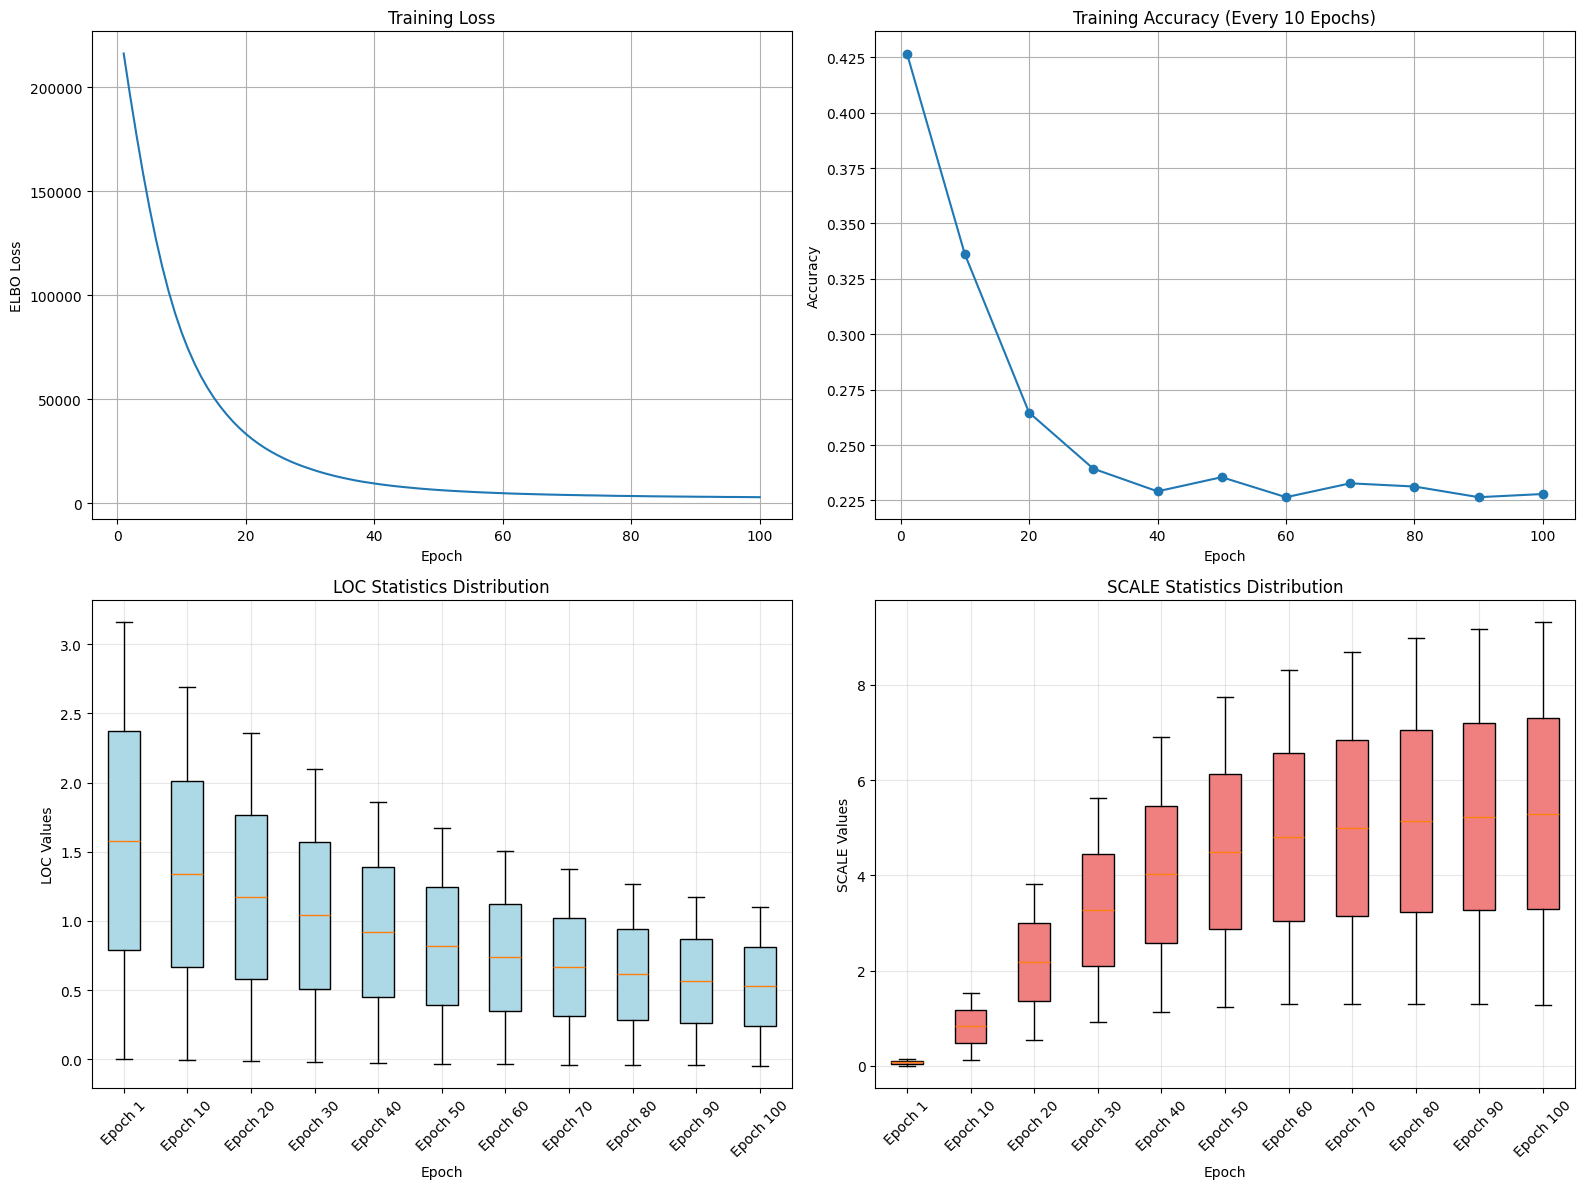

In [16]:
# Plot all results including weight and bias statistics
plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats)

In [ ]:
#print pyro.get_param_store()
for name, param in pyro.get_param_store().items():
    print(f"{name}: {param.mean().item()} ± {param.std().item()}")  # Print mean and std of each parameter

In [ ]:
weight_stats #turns to df

In [ ]:
bias_stats

In [ ]:
accuracies

In [ ]:
weight_means = []
weight_stds = []
bias_means = []
bias_stds = []

In [ ]:
for name, param in pyro.get_param_store().items():
    print(f"Parameter: {name}, Mean: {param.mean().item()}, Std: {param.std().item()}")
    if 'AutoDiagonalNormal.loc' in name:
        weight_means.append(param.mean().item())
        weight_stds.append(param.std().item())
    elif 'AutoDiagonalNormal.scale' in name:
        bias_means.append(param.mean().item())
        bias_stds.append(param.std().item())

In [ ]:
weight_means

In [ ]:
#pyro.clear_param_store()

# Ensure model and guide are on the correct device
#bayesian_model.to(device)
#guide.to(device)

#train_loader, test_loader = load_data(batch_size=54)
#train_svi(bayesian_model, guide, svi, train_loader, num_epochs=0)

In [17]:
# save the model
model_path = 'results_eurosat/bayesian_cnn_model_1std1_100_epoch_tanh.pth'
torch.save(bayesian_model.state_dict(), model_path)

# save the guide
guide_path = 'results_eurosat/bayesian_cnn_guide_1std1_100_epoch_guide_tanh.pth'
torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
pyro_param_store_path = 'results_eurosat/pyro_param_store_1std1_100_epoch_tanh.pkl'
pyro.get_param_store().save(pyro_param_store_path)

In [18]:
import numpy as np

In [19]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, loader_of_interest, num_samples=10):
    model.eval()
    guide.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader_of_interest, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace(images)
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [20]:
train_labels, train_predictions = predict_data(bayesian_model, train_loader, num_samples=10)

Evaluating: 100%|██████████| 400/400 [00:16<00:00, 24.35it/s]


In [21]:
train_cm = confusion_matrix(train_labels, train_predictions)

In [22]:
#print accuracy from confusion matrix
train_accuracy = np.trace(train_cm) / np.sum(train_cm)
print(f"Train accuracy from confusion matrix: {train_accuracy * 100:.6f}%")

Train accuracy from confusion matrix: 35.902778%


In [23]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:04<00:00, 23.64it/s]


In [24]:
cm = confusion_matrix(all_labels, all_predictions)

In [25]:
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

Accuracy from confusion matrix: 34.277778%


In [ ]:
# print pyro parameters
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape} - {value.mean().item():.4f} ± {value.std().item():.4f}")

60.092593% for the 10 epoch

In [ ]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    # make a mark to the diagonal
    plt.plot([0, cm.shape[1]-1], [0, cm.shape[0]-1], color='red', linestyle='--', linewidth=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

In [ ]:
# save the model
#model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
#torch.save(bayesian_model.state_dict(), model_path)

# save the guide
#guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
#torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
#pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'
#pyro.get_param_store().save(pyro_param_store_path)

In [ ]:
kataguediemdeh


In [ ]:
def train_svi_early_save(model, guide, svi, train_loader, num_epochs=10, patience=3, min_delta=0.001):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Early stopping variables
    best_accuracy = 0.0
    best_epoch = 0
    patience_counter = 0
    best_model_state = None
    best_guide_state = None
    best_pyro_params = None
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Check for improvement
            if epoch_accuracy > best_accuracy + min_delta:
                best_accuracy = epoch_accuracy
                best_epoch = epoch + 1
                patience_counter = 0
                
                # Save best model states
                best_model_state = model.state_dict().copy()
                best_guide_state = guide.state_dict().copy()
                best_pyro_params = pyro.get_param_store().get_state().copy()
                
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% *** NEW BEST ***")
            else:
                patience_counter += 1
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% (Best: {best_accuracy*100:.2f}% at epoch {best_epoch})")
                
                # Early stopping check
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered! No improvement for {patience} evaluations.")
                    print(f"Best accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")
                    
                    # Restore best model
                    model.load_state_dict(best_model_state)
                    guide.load_state_dict(best_guide_state)
                    pyro.get_param_store().set_state(best_pyro_params)
                    
                    break
            
            model.train()  # Set back to training mode
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # If training completed without early stopping, still restore best model
    if patience_counter < patience and best_model_state is not None:
        print(f"\nTraining completed. Restoring best model from epoch {best_epoch} (accuracy: {best_accuracy*100:.2f}%)")
        model.load_state_dict(best_model_state)
        guide.load_state_dict(best_guide_state)
        pyro.get_param_store().set_state(best_pyro_params)
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, best_epoch, best_accuracy

In [ ]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with early stopping
losses, accuracies, accuracy_epochs, best_epoch, best_accuracy = train_svi(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100, 
    patience=3,  # Stop if no improvement for 3 accuracy evaluations (30 epochs)
    min_delta=0.001  # Minimum improvement threshold (0.1%)
)

print(f"\nFinal Results:")
print(f"Best training accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_epochs, accuracies, 'o-')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.axhline(y=best_accuracy, color='red', linestyle=':', alpha=0.7)
plt.title('Training Accuracy (Every 10 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os

In [ ]:
def train_svi_with_tensorboard(model, guide, svi, train_loader, num_epochs=10, log_dir='runs/bayesian_cnn'):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Log loss to TensorBoard every epoch
        writer.add_scalar('Loss/ELBO', avg_loss, epoch + 1)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Log accuracy to TensorBoard
            writer.add_scalar('Accuracy/Train', epoch_accuracy, epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # Close the writer
    writer.close()
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

Feature TODO:
1. Record loss after each epoch
2. Send result to GPU